## Ci√™ncia de Dados e Analytics - PUC-RIO
### Sprint: An√°lise de Dados e Boas Pr√°ticas (40530010055_20240_01)
### Aluno: Andrieles de Souza Rodrigues
### MVP: Classifica√ß√£o

Dataset: apple_quality.csv

Fonte do dataset: https://www.kaggle.com/datasets/sohaibmoradi/almond-types-classification

## Sobre o dataset

O dataset utilizado neste arquivo foi obtido no Kaggle e foi publicado sob a licen√ßa [CC0](https://creativecommons.org/publicdomain/zero/1.0/). Nele, encontramos 2802 registros com atributos que podem ser utilizados para identificar tr√™s variedades de am√™ndoas. Os atributos foram obtidos atrav√©s de uma t√©cnica de processamento de imagem ou derivadas delas e descrevem a am√™ndoa dimensionalmente.

Os atributos s√£o:

| Nome do Atributo | Descri√ß√£o do Atributo |
|------------------------|-----------------------------|
| Length (major axis) | Comprimento da am√™ndoa na imagem (com base no n√∫mero de pixels) |
| Width (minor axis)    | Largura da am√™ndoa na imagem (com base no n√∫mero de pixels) |
| Thickness (depth) | Espessura da am√™ndoa na imagem (com base no n√∫mero de pixels) |
| Area                    | √Årea da regi√£o da am√™ndoa detectada na imagem |
| Perimeter               | Comprimento total do contorno da am√™ndoa |
| Roundness           | Circularidade da am√™ndoa: 4 * √°rea / ( œÄ * comprimento ** 2) |
| Solidity                 | √Årea / √°rea_convexa |
| Compactness             | per√≠metro**2 / (4 * œÄ * √°rea) |
| Aspect Ratio    | Comprimento / Largura |
| Eccentricity          | sqrt(1 - ( Largura / Comprimento ) **2 ) |
| Extent                | √Årea / √°rea_bbox (caixa delimitadora) |
| Convex hull(convex area) | Menor conjunto convexo que cont√©m os pontos delimitadores |
| Type (TARGET)                   | Tipo de Am√™ndoa |



Nosso objetivo neste trabalho √© criar um classificador que, com base nos atributos de dimensionalidade da am√™ndoa, possa determinar seu tipo (target).

## Carga dos modulos python e dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da valida√ß√£o cruzada
from sklearn.model_selection import cross_val_score # para executar a valida√ß√£o cruzada
from sklearn.metrics import accuracy_score # para a exibi√ß√£o da acur√°cia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo √Årvore de Classifica√ß√£o
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier # algoritmo RF (ensemble)

from sklearn.preprocessing import MinMaxScaler # normaliza√ß√£o

from typing_extensions import DefaultDict #para acessar raw online

In [3]:

# Carga do dataset para um Dataframe

url_dataset = 'https://raw.githubusercontent.com/Andrieles/datascience/main/datasets/Almond.csv'

df = pd.read_csv(url_dataset,sep=',')

df.head()

Unnamed: 0  Length (major axis)  Width (minor axis)  Thickness (depth)  \
0           0                  NaN          227.940628         127.759132   
1           1                  NaN          234.188126         128.199509   
2           2                  NaN          229.418610         125.796547   
3           3                  NaN          232.763153         125.918808   
4           4                  NaN          230.150742         107.253448   

      Area   Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  \
0  22619.0  643.813269        NaN  0.973384     1.458265           NaN   
1  23038.0  680.984841        NaN  0.957304     1.601844           NaN   
2  22386.5  646.943212        NaN  0.967270     1.487772           NaN   
3  22578.5  661.227483        NaN  0.965512     1.540979           NaN   
4  19068.0  624.842706        NaN  0.951450     1.629395           NaN   

   Eccentricity    Extent  Convex hull(convex area)   Type  
0           NaN  0.681193                   23237.5  MAMRA  
1           NaN  0.656353                   24065.5  MAMRA  
2           NaN  0.683620                   23144.0  MAMRA  
3           NaN  0.685360                   23385.0  MAMRA  
4           NaN  0.714800                   20041.0  MAMRA

## An√°lise explorat√≥ria

In [4]:
df.shape

(2803, 14)


An√°lise: Para come√ßar, podemos ver que o dataframe possui **14 colunas** e **2803 registros**.


In [5]:
df.dtypes

Unnamed: 0                    int64
Length (major axis)         float64
Width (minor axis)          float64
Thickness (depth)           float64
Area                        float64
Perimeter                   float64
Roundness                   float64
Solidity                    float64
Compactness                 float64
Aspect Ratio                float64
Eccentricity                float64
Extent                      float64
Convex hull(convex area)    float64
Type                         object
dtype: object

An√°lise: O primeiro atributo da tabela ser√° descartado, pois se trata de um √≠ndice que n√£o tem import√¢ncia para o nosso trabalho. Os atributos de ponto flutuante s√£o nossos atributos preditores. O √∫ltimo atributo √© nosso target e representa o tipo de am√™ndoa.

In [6]:
df.describe()

Unnamed: 0  Length (major axis)  Width (minor axis)  \
count  2803.000000          1946.000000         1861.000000   
mean   1401.000000           290.609274          171.025915   
std     809.300727            62.719433           29.916529   
min       0.000000           151.335266           88.050529   
25%     700.500000           245.966293          149.453659   
50%    1401.000000           279.879883          170.168365   
75%    2101.500000           330.508575          190.640427   
max    2802.000000           515.352478          258.569794   

       Thickness (depth)          Area    Perimeter    Roundness     Solidity  \
count        1799.000000   2803.000000  2803.000000  1946.000000  2803.000000   
mean          109.705378  26511.117374   743.863770     0.470466     0.955828   
std            18.940597  13782.561344   230.632076     0.118673     0.039596   
min            59.494278   6037.000000   311.563489     0.173748     0.718772   
25%            97.091682  16211.500000   571.730009     0.384810     0.944579   
50%           110.280136  23440.500000   707.487369     0.472718     0.970422   
75%           121.392773  33451.000000   878.896530     0.577553     0.981484   
max           181.845200  89282.000000  1864.947387     0.697293     0.992889   

       Compactness  Aspect Ratio  Eccentricity       Extent  \
count  2803.000000   1004.000000   1004.000000  2803.000000   
mean      1.825233      1.753216      0.813114     0.724587   
std       0.794058      0.206616      0.041312     0.047474   
min       1.164469      1.400082      0.699897     0.454538   
25%       1.357398      1.612490      0.784476     0.701673   
50%       1.576412      1.705716      0.810120     0.733720   
75%       1.965953      1.833339      0.838141     0.757551   
max       9.660057      2.731251      0.930563     0.845813   

       Convex hull(convex area)  
count               2803.000000  
mean               27696.218159  
std                14237.347610  
min                 6355.000000  
25%                17088.500000  
50%                24589.000000  
75%                34863.250000  
max                90642.500000

An√°lise: A contagem de registros est√° diferente de 2803 em algumas colunas, o que deve indicar a exist√™ncia de valores nulos. √â poss√≠vel notar tamb√©m que h√° uma diferen√ßa nas propor√ß√µes, o que parece adequado √† natureza dos diversos tipos de medi√ß√µes realizadas para obten√ß√£o dos dados. Abaixo, vou visualizar esses dados em histogramas e um boxplot. Vamos tentar visualizar como est√£o distribu√≠dos.

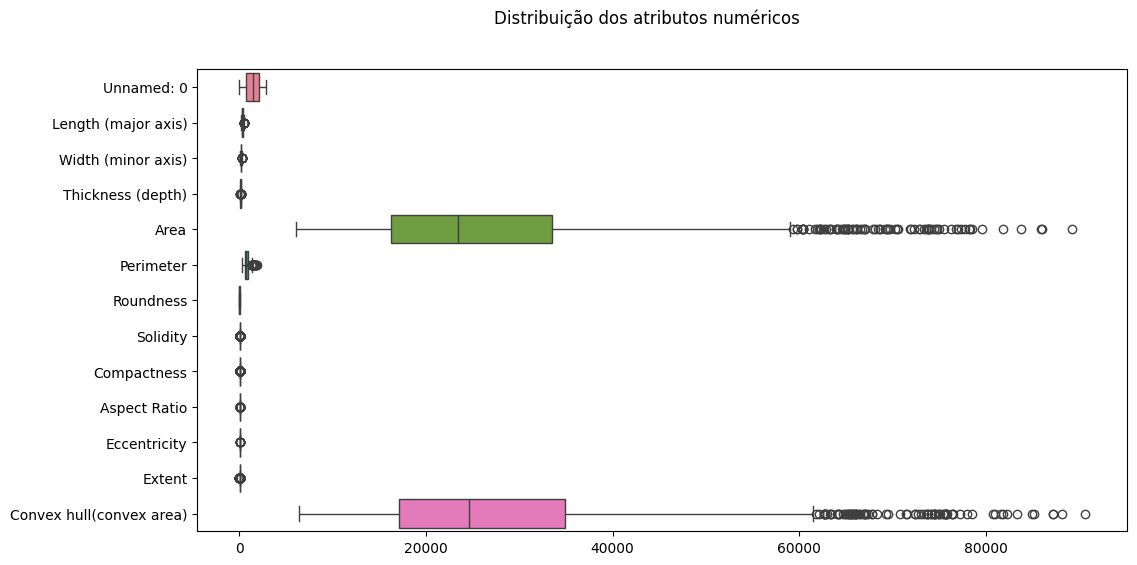

In [7]:
# Definir o tamanho da figura
plot1 = plt.figure(figsize=(12, 6))  # Ajuste os valores conforme necess√°rio

# T√≠tulo do gr√°fico
plot1.suptitle('Distribui√ß√£o dos atributos num√©ricos')

# Criar o boxplot na horizontal
sns.boxplot(data=df, orient='h')

# Exibir o gr√°fico
plot1.show()

An√°lise: A distribui√ß√£o dos dados tamb√©m n√£o me surpreende. Muitos valores extrapolam com bastante intensidade os quartis, principalmente os atributos que medem a √°rea do objeto (am√™ndoa).

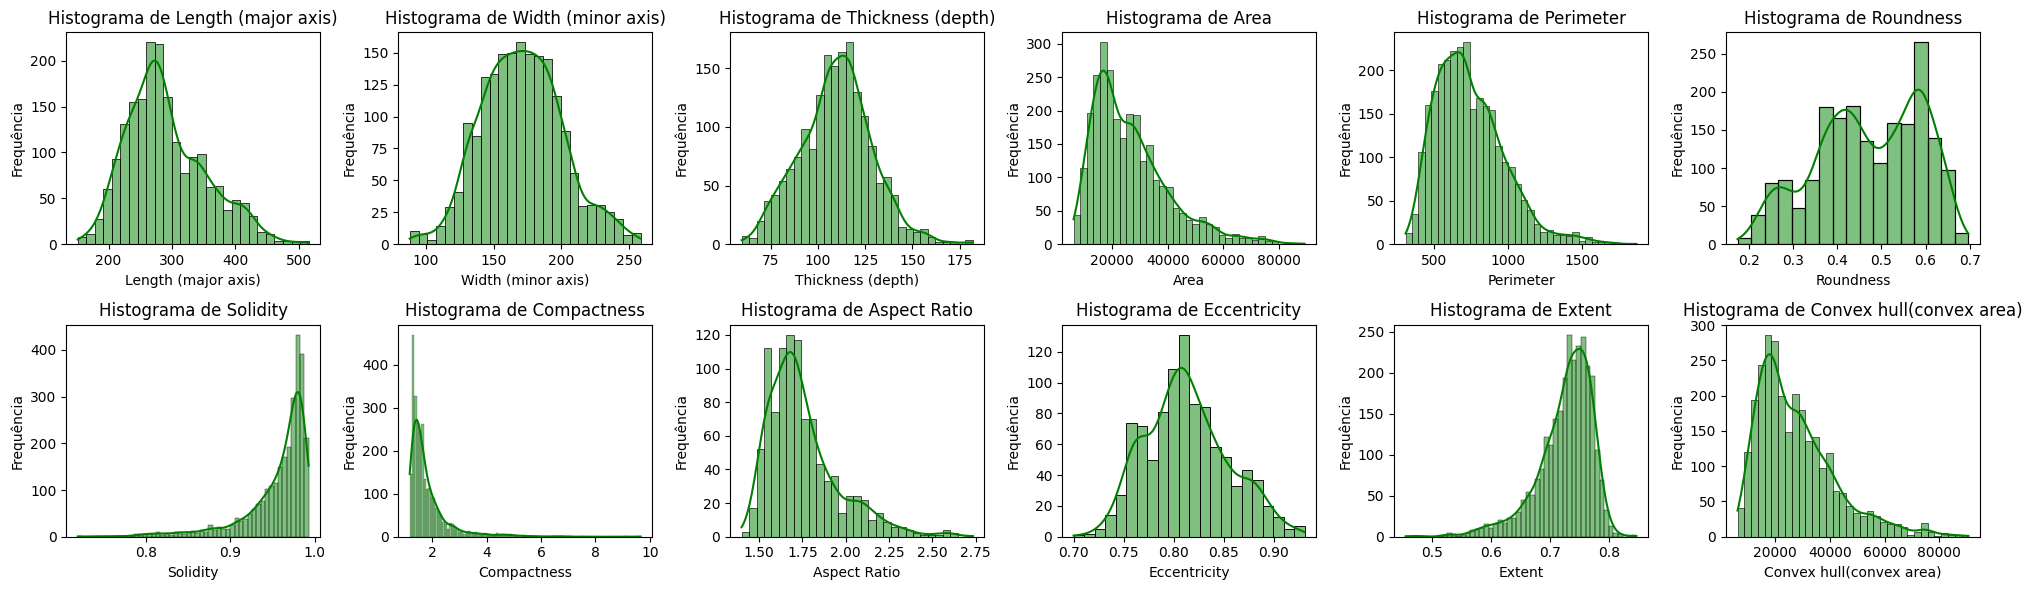

In [8]:
# Seleciona as colunas do tipo float64
float_columns = df.select_dtypes(include=['float64']).columns

# Define o n√∫mero de colunas para a grade de subplots
num_cols = 6
num_rows = (len(float_columns) + num_cols - 1) // num_cols

# Cria a figura e os eixos para os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3 * num_rows))

# Achata a matriz de eixos para facilitar a itera√ß√£o
axes = axes.flatten()

# Itera sobre as colunas e os eixos
for i, column in enumerate(float_columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color='green')
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequ√™ncia')

# Remove eixos n√£o utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout e exibe os histogramas
plt.tight_layout()
plt.show()


An√°lise: Verificando os histogramas acima relativos aos valores dos atributos preditores, d√° para concluir que, em grande parte, eles n√£o possuem uma distribui√ß√£o normal. Vou optar por fazer uma normaliza√ß√£o sem padroniza√ß√£o.

In [9]:
# Calcular a matriz de correla√ß√£o
corr_matrix = df.corr(numeric_only=True)

# Criar um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlGn', square=True)

# Definir t√≠tulo
plt.title('Matriz de correla√ß√£o b√°sica')
plt.show()

An√°lise: Tratando-se de dados relativos √†s dimens√µes de um objeto org√¢nico, novamente n√£o fico surpreso com os resultados da matriz de correla√ß√£o. A maioria dos dados tem uma correla√ß√£o forte positiva. As que t√™m correla√ß√£o forte negativa s√£o poucas e bem pr√≥ximas de -1. Continuo propenso a fazer uma normaliza√ß√£o sem padroniza√ß√£o.

In [10]:
# calcular a porcentagem de valores nulos em cada coluna
null_percentages = df.isnull().mean() * 100

# classificar em ordem decrescente
null_percentages = null_percentages.sort_values(ascending=False)

# Criar o gr√°fico de colunas
plt.figure(figsize=(10, 6))

# Arredondar as porcentagens para dois decimais
null_percentages_rounded = [round(p, 2) for p in null_percentages]

# Criar uma paleta de cores baseada na classifica√ß√£o das porcentagens
ranks = null_percentages.rank(method='dense', ascending=False).astype(int)
colors = sns.color_palette("RdYlGn", ranks.max())
palette = [colors[i - 1] for i in ranks]

# Criar o gr√°fico de barras com a paleta de cores
ax = sns.barplot(x=null_percentages.values, y=null_percentages.index, palette=palette)

# Adicionar t√≠tulos e r√≥tulos
plt.title('Percentual de Valores Nulos por Coluna')
plt.xlabel('Percentual de Valores Nulos (%)')
plt.ylabel('Colunas')

# Adicionar r√≥tulos de percentual acima das colunas
for p in ax.patches:
    if p.get_width() > 0:  # Exibir apenas se o valor for maior que 0
        ax.annotate(f'{p.get_width():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

# Exibir o gr√°fico
plt.show()

# identifica colunas para drop posterior
columns_to_drop = null_percentages[null_percentages > 60].index


An√°lise: Esses dados me surpreenderam agora. Duas colunas excedem os 64% de nulidade. Estou tentado a excluir esses atributos. Para resolver os campos nulos de forma geral, vou optar por substitu√≠-los pela m√©dia dos atributos. Usar uma mediana pode propagar uma caracter√≠stica de um objeto espec√≠fico para o conjunto, e isso n√£o me parece adequado.

In [11]:
# Calcular a porcentagem de cada categoria
porcentagem = df['Type'].value_counts(normalize=True) * 100

# Transformar em DataFrame
df_porcentagem = porcentagem.reset_index()
df_porcentagem.columns = ['categoria', 'porcentagem']

# Criar o gr√°fico de pizza
plt.figure(figsize=(8, 8))
plt.pie(df_porcentagem['porcentagem'], labels=df_porcentagem['categoria'], autopct='%1.1f%%', colors=sns.color_palette("muted", len(df_porcentagem)))
plt.title('Porcentagem de Atributos Target')
plt.show()

An√°lise: Finalmente, nosso atributo target. Tr√™s valores definitivamente bem distribu√≠dos entre os registros do dataset.

## Pr√©-processamento

In [12]:
# Remove a coluna 'Unnamed: 0'

df_ajustado = df.drop('Unnamed: 0', axis=1)

Descri√ß√£o: A primeira opera√ß√£o que realizei foi a exclus√£o do atributo ‚ÄúUnnamed: 0‚Äù. Essa coluna √© um √≠ndice que n√£o √© necess√°rio para o treinamento do classificador. Nesse ponto, criei um dataframe √† parte para os ajustes.

In [13]:
# Substituindo valores nulos pela m√©dia

# Selecionando apenas as colunas do tipo float64
float_cols = df_ajustado.select_dtypes(include=['float64']).columns

# Substituindo os valores nulos pela m√©dia de cada coluna
df_ajustado[float_cols] = df_ajustado[float_cols].apply(lambda x: x.fillna(x.mean()))

# df_ajustado.head(30)

Descri√ß√£o: A segunda opera√ß√£o √© o tratamento dos valores nulos. Decidi fazer a substitui√ß√£o dos valores nulos por m√©dias, conforme pondera√ß√µes feitas na an√°lise de dados.

In [14]:
# Fazendo uma c√≥pia profunda do dataframe
df_normalizado = df_ajustado.copy(deep=True)

Descri√ß√£o: Nesse ponto, decidi criar outro dataframe a partir do dataframe com os ajustes anteriores. A ideia √© treinar o classificador com os dados normalizados e n√£o normalizados e comparar a acur√°cia de ambos.

In [15]:
# Selecionando apenas colunas do tipo float64
float_cols = df_normalizado.select_dtypes(include=['float64']).columns

# Aplicando Min-Max Scaler
scaler = MinMaxScaler()
df_normalizado[float_cols] = scaler.fit_transform(df_normalizado[float_cols])

Descri√ß√£o: Aqui, eu fa√ßo a normaliza√ß√£o dos dados de ponto flutuante em apenas um dataframe (df_normalizado), conforme considera√ß√µes feitas na fase de an√°lise explorat√≥ria.

In [16]:
# Fazendo uma c√≥pia profunda do dataframe
df_dropado = df_normalizado.copy(deep=True)

Descri√ß√£o: Nesse ponto, decidi ramificar os dataframes mais uma vez. Desta vez, a partir do dataframe normalizado, criei um dataframe do qual vou remover as colunas de atributos que possu√≠am mais de 60% de valores nulos. Vou treinar o classificador com esse arquivo e comparar com a acur√°cia dos outros dois.

In [17]:
# remover as colunas
df_dropado = df_dropado.drop(columns=columns_to_drop)

Descri√ß√£o: Aqui, eu excluo as colunas com mais de 60% de nulidade. O valor de ‚Äúcolumns_to_drop‚Äù foi definido na fase de an√°lise explorat√≥ria para reaproveitar o c√≥digo que apura os atributos com maior nulidade.

## Treino do classificador

In [18]:

## Criando os folds para a valida√ß√£o cruzada
num_particoes = 10 # n√∫mero de folds da valida√ß√£o cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42) # faz o particionamento em 10 folds

# Modelagem

# Definindo uma seed global para esta c√©lula de c√≥digo
np.random.seed(42)

# Listas para armazenar os modelos e os nomes
models = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('ExtraTrees', ExtraTreesClassifier()))

# Cria um dicion√°rio para guardar os resultados m√©dios para gr√°fico final
data = {
    'Categoria': [],
    'Valor': [],
    'Grupo': []
}

Descri√ß√£o: Aqui, eu defino dicion√°rios e parametros para o treinamento. Vou usar cinco moldelos e farei o parcionamento dos dados em 10 folds.

In [19]:
# Separa√ß√£o em bases de treino e teste (holdout)
array = df_ajustado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois n√£o √© relevante para o treinamento.
X = array[:,0:12] # atributos
y = array[:,12] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divis√£o


# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  # names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # m√©dia e desvio padr√£o dos 10 resultados da valida√ß√£o cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Sem normaliza√ß√£o')


KNN: 0.483500 (0.021836)
CART: 0.763603 (0.023955)
NB: 0.500879 (0.025440)
RandomForest: 0.837181 (0.017693)
ExtraTrees: 0.860387 (0.017630)


Descri√ß√£o: Aqui, eu fa√ßo o treinamento dos modelos com base no dataframe com pr√©-processamento b√°sico. Isto √©, sem normaliza√ß√£o e exclus√£o de colunas com alta nulidade.

In [20]:
# Separa√ß√£o em bases de treino e teste (holdout)
array = df_normalizado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois n√£o √© relevante para o treinamento.
X = array[:,0:12] # atributos
y = array[:,12] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divis√£o

# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # m√©dia e desvio padr√£o dos 10 resultados da valida√ß√£o cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Normalizado')

KNN: 0.789921 (0.031380)
CART: 0.763605 (0.026217)
NB: 0.559778 (0.032581)
RandomForest: 0.837629 (0.017781)
ExtraTrees: 0.868853 (0.017158)


Descri√ß√£o: Aqui, eu fa√ßo o treimanato com o dataframe normalizado, mas sem exclus√£o de atributos com alta nulidade.

In [21]:
# Separa√ß√£o em bases de treino e teste (holdout)
array = df_dropado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois n√£o √© relevante para o treinamento.
X = array[:,0:10] # atributos
y = array[:,10] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divis√£o

# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # m√©dia e desvio padr√£o dos 10 resultados da valida√ß√£o cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Excluidos(Nulos > 60)')

KNN: 0.787698 (0.027384)
CART: 0.744853 (0.030514)
NB: 0.541946 (0.030405)
RandomForest: 0.835403 (0.022687)
ExtraTrees: 0.862603 (0.022286)


Descri√ß√£o: Finalmente, nesta etapa, eu fa√ßo o treinamento do modelo usando o dataframe normalizado e com exclus√£o dos atributos com alta nulidade (acima de 60%).

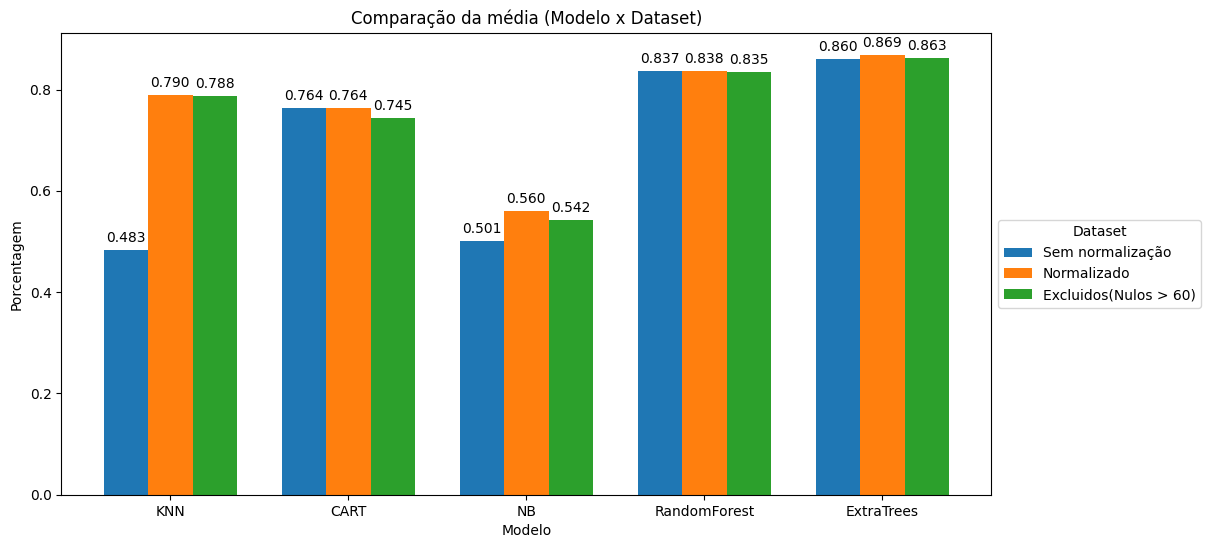

In [22]:
# Criando dataframe para cria√ß√£o do gr√°fico
result_data = pd.DataFrame(data)

# Configurando o gr√°fico
fig, ax = plt.subplots(figsize=(12, 6))

# Obtendo categorias e grupos √∫nicos
categorias = result_data['Categoria'].unique()
grupos = result_data['Grupo'].unique()

# Definindo a largura das barras
bar_width = 0.25

# Definindo as posi√ß√µes das barras
bar_positions = np.arange(len(categorias))

# Plotando as barras para cada grupo
for i, grupo in enumerate(grupos):
    valores = result_data[result_data['Grupo'] == grupo]['Valor']
    ax.bar(bar_positions + i * bar_width, valores, width=bar_width, label=grupo)

# Adicionando os valores no topo das colunas
for i, grupo in enumerate(grupos):
    valores = result_data[result_data['Grupo'] == grupo]['Valor']
    for j, valor in enumerate(valores):
        ax.text(bar_positions[j] + i * bar_width, valor + 0.01, f'{valor:.3f}', ha='center', va='bottom')

# Ajustando labels e exibindo gr√°fico
ax.set_xlabel('Modelo')
ax.set_ylabel('Porcentagem')
ax.set_title('Compara√ß√£o da m√©dia (Modelo x Dataset)')
ax.set_xticks(bar_positions + bar_width * (len(grupos) - 1) / 2)
ax.set_xticklabels(categorias)
ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Observa√ß√£o, n√£o usei o Seaborn nesse √∫ltimo gr√°fico por conta de um bug
# na renderiza√ß√£o que incluia um "0.00" sem explica√ß√£o e eventualmente poderia
# causar uma leitura equivocada.

Descri√ß√£o: Nesta √∫ltima etapa, compilo o resultado do treinamento com base nos nossos tr√™s dataframes em um gr√°fico de barras. Abaixo, fa√ßo a an√°lise dos resultados.

### Analise da acur√°cia dos modelos baseado nos tr√™s dataframes: üìä

Basicamente, os modelos baseados em ensemble de √°rvores de decis√£o se sa√≠ram melhor nos tr√™s tipos de pr√©-processamento que fizemos, com o ExtraTrees tendo a melhor acur√°cia m√©dia entre todos, utilizando dados normalizados sem exclus√£o de nulidades. Outro modelo que se destaca, mesmo n√£o tendo a melhor acur√°cia, √© o KNN, que deu um salto nos resultados com o uso de dados normalizados.


## Considera√ß√µes finais do trabalho:

Este trabalho reflete para mim a complexidade e os desafios enfrentados na constru√ß√£o de um classificador eficiente. Utilizando este dataset obtido no Kaggle, composto por atributos dimensionais de am√™ndoas, foi poss√≠vel explorar diversas t√©cnicas de an√°lise explorat√≥ria, pr√©-processamento e um pouco de modelagem.

Inicialmente, a an√°lise explorat√≥ria revelou a presen√ßa de valores nulos e a necessidade de normaliza√ß√£o dos dados, devido √† aus√™ncia de distribui√ß√£o normal em muitos atributos. A decis√£o de substituir valores nulos pela m√©dia dos atributos foi fundamentada na tentativa de evitar a propaga√ß√£o de caracter√≠sticas espec√≠ficas de um objeto para o conjunto de dados.

A exclus√£o de atributos com mais de 60% de nulidade e a normaliza√ß√£o dos dados foram etapas cruciais para melhorar a qualidade do dataset. A cria√ß√£o de diferentes dataframes permitiu a compara√ß√£o entre modelos treinados com dados brutos, normalizados e com exclus√£o de atributos de alta nulidade.

Os resultados mostraram que um bom trabalho de pr√©-processamento pode mudar radicalmente a performance de um modelo.

Em conclus√£o, este trabalho demonstrou a import√¢ncia do pr√©-processamento embasado por uma an√°lise explorat√≥ria de dados adequada para a constru√ß√£o de classificadores eficientes. As t√©cnicas aplicadas e os resultados obtidos fornecem uma base s√≥lida para futuras pesquisas e aprimoramentos na minha carreira na √°rea de an√°lise de dados.
